In [1]:
import sys, os
# os.environ["THEANO_FLAGS"] = "device=cuda"  # use gpu
sys.path.append("../../../")
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import logging
from importlib import reload
from copy import copy

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Active grids: ['regular']
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!


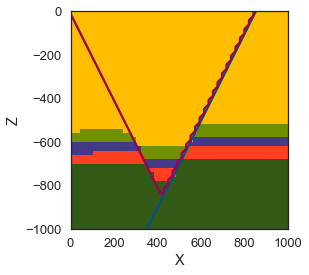

In [2]:
geo_model = gp.load_model(
    'Tutorial_ch1-9b_Fault_relations', 
    path= '../../data/gempy_models', 
    recompile=True
)
gp.compute_model(geo_model)
gp.plot.plot_section(geo_model, show_data=True)

In [3]:
logging.basicConfig(level=logging.DEBUG, format='%(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# NUMPY TOPOLOGY

In [4]:
import topology_numpy as tpn

In [5]:
# get the lb, fb from block matrix
lb, fb = tpn.lithblock_to_lb_fb(geo_model)
# generate unique labels block from combination of lb and fb's
labels = tpn.get_labels_block(lb, fb).reshape(50, 50, 50)
# shift the blocks to get the "topology block"
shift_blocks = tpn.get_topo_block(labels, n_shift=1)
# remove non-edge sums
shift_blocks[np.isin(shift_blocks, 2 * np.unique(labels))] = 0
# extract edges from the shift block
edges = tpn.get_edges(shift_blocks, labels, 1)
# calculate centroids of geobodies
centroids = tpn.get_centroids(labels)
# ----------------------------------------------
# --- theano end
# ----------------------------------------------
# create a LOT to go from sums to lith id's
node_to_layer_LOT = tpn.get_lith_lot(labels, 2, 5)

fb shp: (2, 125000); fb unique: [0 1 2 3]
fb 0: [0 1]
fb 1: [2 3]
lb shp: (125000,); lb unique: [3 4 5 6 7]
lb shift unique: [4 5 6 7 8]
labels shp: (3, 125000)

unique labels:
000000001 <-> 1
000000010 <-> 2
000000100 <-> 4
000001000 <-> 8
000010000 <-> 16
000100000 <-> 32
001000000 <-> 64
010000000 <-> 128
100000000 <-> 256

summed labels:
sum unique: [ 21  25  26  37  41  42  69  73  74 133 137 138 261 265 266]
000010101 <-> 21
000011001 <-> 25
000011010 <-> 26
000100101 <-> 37
000101001 <-> 41
000101010 <-> 42
001000101 <-> 69
001001001 <-> 73
001001010 <-> 74
010000101 <-> 133
010001001 <-> 137
010001010 <-> 138
100000101 <-> 261
100001001 <-> 265
100001010 <-> 266
sum_x shp: (49, 50, 50)
sum_y shp: (50, 49, 50)
sum_z shp: (50, 50, 49)
slx slice(0, -1, None); sly slice(0, -1, None); slz slice(0, -1, None)
(3, 49, 49, 49)
21: [20.74193548 24.5        36.96296296]
25: [ 4.06751323 24.29322751 31.14814815]
26: [42.  24.5 34.5]
37: [20.83333333 24.5        17.06666667]
41: [ 6.84     

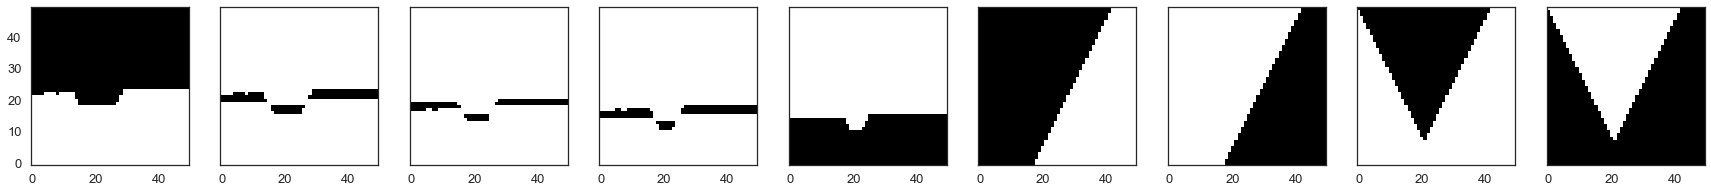

In [356]:
reload(tpn)
n_faults = 2
n_liths = 5

lb, fb = tpn.lithblock_to_lb_fb(geo_model)
topology_labels = tpn.get_topology_labels(lb, fb, n_liths)

fig, axs = plt.subplots(ncols=topology_labels.shape[0], figsize=(30, 5), sharey=True)

for arr, ax in zip(topology_labels, axs):
    ax.imshow(arr.reshape(50, 50, 50)[:, 24, :].T, origin="lower")

In [358]:
n_shift = 1
res = (50, 50, 50)

topology_block = topology_labels.reshape(n_faults * 2 + n_liths, *res)

x = np.logical_or(
    topology_block[:, n_shift:, :, :],
    topology_block[:, :-n_shift, :, :]
)
logging.debug(f"x shift shp: {x.shape}")

y = np.logical_or(
    topology_block[:, :, n_shift:, :],
    topology_block[:, :, :-n_shift, :]
)
logging.debug(f"y shift shp: {y.shape}")

z = np.logical_or(
    topology_block[:, :, :, n_shift:],
    topology_block[:, :, :, :-n_shift]
)
logging.debug(f"z shift shp: {z.shape}")

x shift shp: (9, 49, 50, 50)
y shift shp: (9, 50, 49, 50)
z shift shp: (9, 50, 50, 49)


In [359]:
x_flat = x.reshape(n_faults * 2 + n_liths, 49*50*50).astype(int)
y_flat = y.reshape(n_faults * 2 + n_liths, 50*49*50).astype(int)
z_flat = z.reshape(n_faults * 2 + n_liths, 50*50*49).astype(int)
xyz_flat = np.stack((x_flat, y_flat, z_flat))
logging.debug(f"xys shape: {xyz_flat.shape}")
xyz_bin = np.sum(xyz_flat * 2**np.arange(n_faults * 2 + n_liths)[None, ::-1].T, axis=1)
logging.debug(f"xyz bin shape: {xyz_bin.shape}")

xys shape: (3, 9, 122500)
xyz bin shape: (3, 122500)


In [360]:
xyz_uniq = np.unique(xyz_bin)

In [361]:
xyz_flat.shape

(3, 9, 122500)

In [362]:
slice_fit = slice(None, None)
    
slicers = (
    (
        (slice(n_shift, None), slice_fit, slice_fit), 
        (slice(-n_shift), slice_fit, slice_fit)
    ),
    (
        (slice_fit, slice(n_shift, None), slice_fit), 
        (slice_fit, slice(-n_shift), slice_fit)
    ),
    (
        (slice_fit, slice_fit, slice(n_shift, None)), 
        (slice_fit, slice_fit, slice(-n_shift))
    )
)

In [366]:
labels = np.packbits(topology_block, axis=0)[0]
edges = set()

for i, bin_, shp in zip(range(3), xyz_bin, [(49, 50, 50), (50, 49, 50), (50, 50, 49)]):
    bin_ = bin_.reshape(*shp)
    b1 = labels[slicers[i][0]]
    b2 = labels[slicers[i][1]]
    for edge_sum_bin in xyz_uniq:
        if edge_sum_bin == 0:
            continue
#         logging.debug(f"{np.binary_repr(edge_sum_bin).zfill(7)} <-> {edge_sum_bin}")
        filter_ = bin_ == edge_sum_bin
        e1 = b1[filter_]
        e2 = b2[filter_]
        if len(e1) == 0 or len(e2) == 0:
            continue
        if e1[0] == e2[0]:
            continue
        
        edges.add(
            (e1[0],
             e2[0])
        )
        
edges

{(10, 12),
 (10, 13),
 (10, 21),
 (10, 37),
 (12, 10),
 (13, 10),
 (13, 12),
 (18, 10),
 (18, 69),
 (20, 12),
 (20, 36),
 (21, 10),
 (21, 12),
 (21, 13),
 (34, 18),
 (34, 133),
 (36, 20),
 (37, 10),
 (37, 12),
 (37, 20),
 (37, 21),
 (66, 34),
 (66, 133),
 (68, 36),
 (68, 132),
 (69, 10),
 (69, 18),
 (69, 20),
 (69, 36),
 (69, 37),
 (130, 66),
 (130, 133),
 (132, 68),
 (133, 34),
 (133, 36),
 (133, 66),
 (133, 68),
 (133, 69),
 (133, 130),
 (133, 132)}

In [365]:
centroids = tpn.get_centroids(labels)

10: [35.15789474 24.5         7.13157895]
12: [ 9.23024055 24.5         7.        ]
13: [20.83333333 24.5         9.33333333]
18: [37.66197183 24.5        16.98591549]
20: [ 8.05808081 24.92171717 15.71212121]
21: [20.66666667 24.5        12.13333333]
34: [38.24444444 24.5        19.48888889]
36: [ 7.19565217 24.09661836 18.11111111]
37: [20.73333333 24.5        14.53333333]
66: [38.828125 24.5      21.984375]
68: [ 6.84       25.58555556 20.77777778]
69: [20.83333333 24.5        17.06666667]
130: [42.  24.5 34.5]
132: [ 4.06751323 24.29322751 31.14814815]
133: [20.74193548 24.5        36.96296296]


In [131]:
x_bin = np.sum(x_flat * 2**np.arange(7)[None, ::-1].T, axis=0)


for bit in x_uniq:
    logging.debug(f"{np.binary_repr(bit).zfill(7)}")

0000100
0000101
0000111
0001000
0001001
0001011
0001101
0001111
0010000
0010001
0010011
0010101
0010111
0011001
0100000
0100001
0100011
0101001
0101011
0110001
1000000
1000001
1000011
1010001
1010011
1100001
1100011


In [130]:
unique_nodes = {*x_uniq, *y_uniq, *z_uniq}

### bitpacking

In [88]:
x_bits = np.packbits(x, axis=0)
x_bits_uniq = np.unique(x_bits)

for bit in x_bits_uniq:
    logging.debug(f"{np.binary_repr(bit).zfill(8)} -> {bit}")


00001000 -> 8
00001010 -> 10
00001110 -> 14
00010000 -> 16
00010010 -> 18
00010110 -> 22
00011010 -> 26
00011110 -> 30
00100000 -> 32
00100010 -> 34
00100110 -> 38
00101010 -> 42
00101110 -> 46
00110010 -> 50
01000000 -> 64
01000010 -> 66
01000110 -> 70
01010010 -> 82
01010110 -> 86
01100010 -> 98
10000000 -> 128
10000010 -> 130
10000110 -> 134
10100010 -> 162
10100110 -> 166
11000010 -> 194
11000110 -> 198


In [260]:
topo_labels = np.zeros((*labels.shape, n_layers)).reshape(50 * 50 * 50, n_layers)
print(topo_labels.shape)

lb, fb = tpn.lithblock_to_lb_fb(geo_model)
fb -= 1
fb += np.arange(n_faults)[None, :].T
fb = fb.astype(bool).T
print(fb)

lb = lb - lb.min() # + n_faults + 2

for l in range(n_layers):
#     print(l)
    i = np.argwhere(lb == l)
    topo_labels[i, n_layers - l - 1] = True

topo_ndarray = np.concatenate( (topo_labels, fb) , axis=1)

(125000, 5)
[[False  True]
 [False  True]
 [False  True]
 ...
 [ True  True]
 [ True  True]
 [ True  True]]


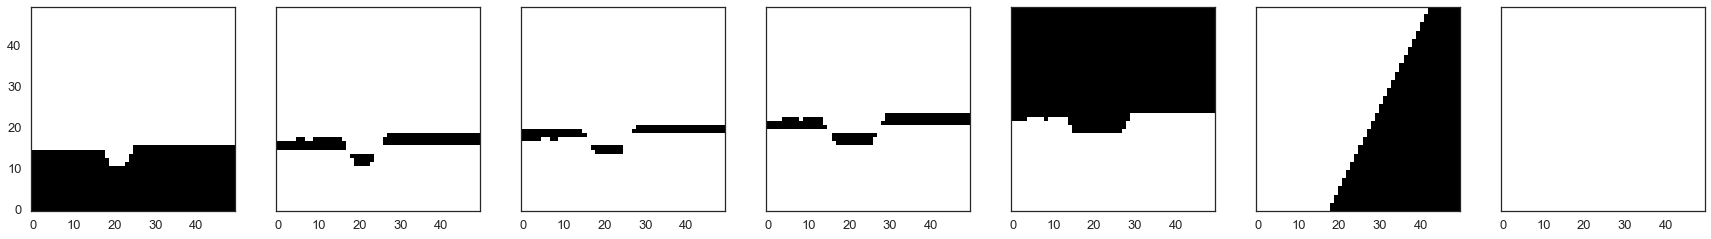

In [292]:
fig, axs = plt.subplots(ncols=topo_ndarray.shape[1], figsize=(30, 5), sharey=True)

for arr, ax in zip(topo_ndarray.T, axs):
    ax.imshow(arr.reshape(50, 50, 50)[:, 24, :].T, origin="lower")

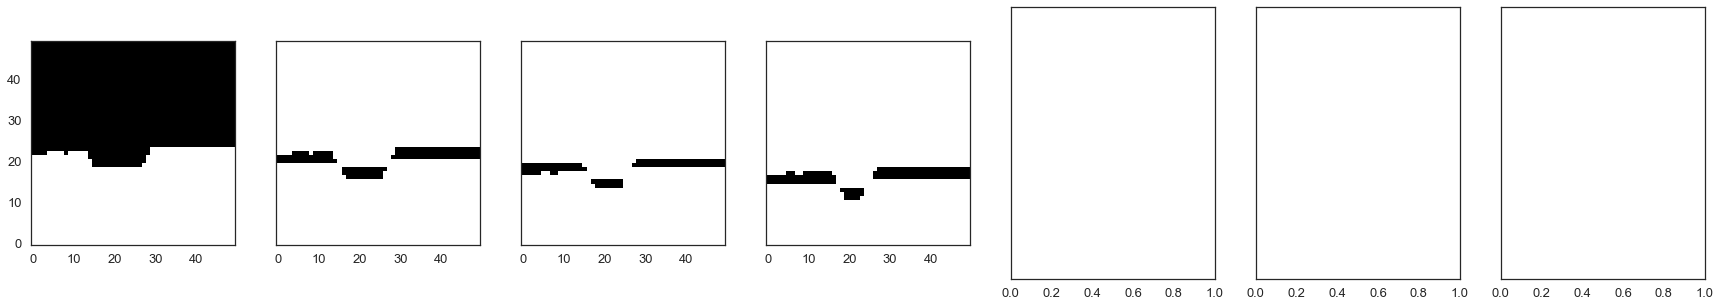

In [266]:
np.logical_or([True, False], [False, False])

array([ True, False])

In [228]:
topo_labels.shape

(125000, 5)

In [229]:
fb.shape

(125000, 2)

In [201]:
topo_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [181]:
lb

array([8, 8, 8, ..., 4, 4, 4])

In [132]:
reload(tpn)

<module 'topology_numpy' from 'C:\\Users\\r02as18\\git\\gempy\\notebooks\\experimental\\topology\\topology_numpy.py'>

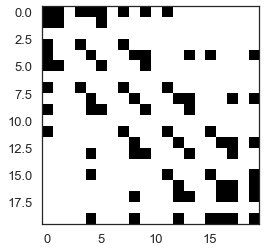

In [139]:
n_faults = 2
n_layers = 5

f_labels = tpn.get_fault_labels(n_faults)
# print(f_labels)

fault_labels_bin = tpn.get_fault_label_comb_bin(f_labels)
# print(bin_str_faults)

lith_labels_bin = tpn.get_lith_labels_bin(n_layers)
# print(bin_str_lith)

adj_matrix_labels = tpn.get_adj_matrix_labels(lith_labels_bin, fault_labels_bin)
adj_matrix_labels

adj_matrix = tpn.get_adj_matrix(edges, adj_matrix_labels, labels)

plt.imshow(adj_matrix)

In [138]:
tri_i, tri_j = np.tril_indices(adj_matrix.shape[0])
topology_vector = adj_matrix[tri_i, tri_j]
topology_vector

array([ True,  True,  True, False, False, False,  True, False, False,
        True,  True, False, False, False,  True,  True,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False,  True,
       False, False, False, False,  True, False, False, False,  True,
        True, False, False, False,  True,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False,  True, False, False, False,
        True,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,

In [174]:
topology_vector.shape

(210,)

In [143]:
import networkx as nx
G = nx.from_numpy_matrix(adj_matrix)

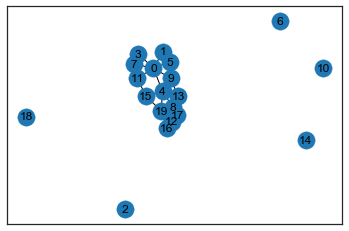

In [148]:
nx.draw_networkx(G)

In [146]:
for edge in G.edges:
    print(edge)

(0, 0)
(0, 1)
(0, 3)
(0, 4)
(0, 5)
(0, 7)
(0, 9)
(0, 11)
(1, 1)
(1, 5)
(3, 3)
(3, 7)
(4, 4)
(4, 8)
(4, 9)
(4, 13)
(4, 15)
(4, 19)
(5, 5)
(5, 9)
(7, 7)
(7, 11)
(8, 8)
(8, 12)
(8, 13)
(8, 17)
(8, 19)
(9, 9)
(9, 13)
(11, 11)
(11, 15)
(12, 12)
(12, 16)
(12, 17)
(12, 19)
(13, 13)
(13, 17)
(15, 15)
(15, 19)
(16, 16)
(16, 17)
(16, 19)
(17, 17)
(17, 19)
(19, 19)


# Other

# Speed comparison

In [628]:
logger.setLevel(logging.CRITICAL)

In [636]:
%%timeit
lb, fb = tpn.lithblock_to_lb_fb(geo_model)
labels = tpn.get_labels_block(lb, fb).reshape(50, 50, 50)
shift_blocks = tpn.get_topo_block(labels, n_shift=1)
shift_blocks[np.isin(shift_blocks, 2*np.unique(labels))] = 0
edges = tpn.get_edges(shift_blocks, labels, 1)
centroids = tpn.get_centroids(labels)
node_to_layer_LOT = tpn.get_lith_lot(labels, 2)

52.9 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [630]:
%%timeit
G, c = tp.compute_topology(geo_model, filter_rogue=True, compute_areas=False)

382 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [631]:
print(f"Speed-up: {375  / 50.7:.02f}x" )

Speed-up: 7.40x


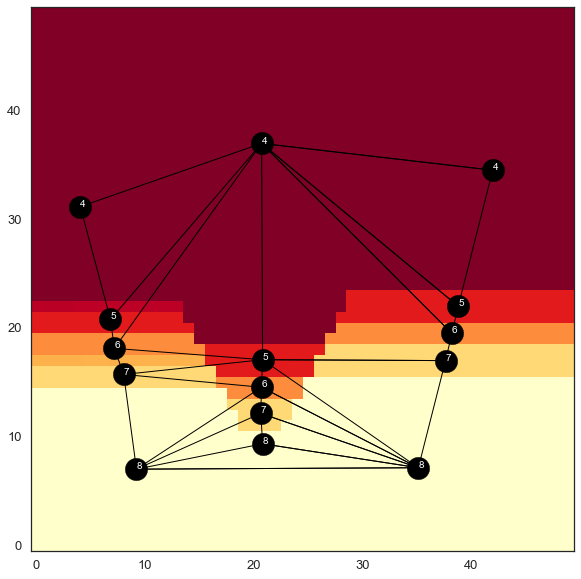

In [634]:
fig = plt.figure(figsize=(10,10))
plt.imshow(geo_model.solutions.block_matrix[-1].reshape(50,50, 50)[:, 24, :].T, origin="lower", cmap="YlOrRd_r")

for edge in edges:
    e1, e2 = edge
    p1 = centroids.get(e1)
    p2 = centroids.get(e2)
    x = (p1[0], p2[0])
    y = (p1[2], p2[2])
    plt.plot(x, y, c="k", linewidth=1)
    
for node in ulabels:
    p = centroids.get(node)
    plt.scatter(p[0], p[2], c="k", s=500)
    plt.text(p[0], p[2], str(node_to_layer_LOT[node]), c="w")

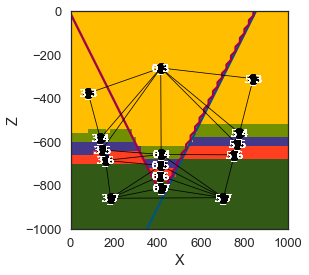

In [635]:
from gempy.assets import topology as tp
G, c = tp.compute_topology(geo_model, filter_rogue=True)
gp.plot.plot_section(geo_model, 24)
gp.plot.plot_topology(geo_model, G, c)